# Python workbook for the graphs for the DoSI publication, taking the results from the analysis without rerunning it.

In [2]:
# Imports and reading

import pandas as pd
import numpy as np

import re
from sklearn.linear_model import LinearRegression
from scipy.stats import linregress
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
import nbformat

import plotly.express as px
import plotly.graph_objects as go

VERSION_FOR_DATA = "v25"
VERSION_FOR_FITPARAMETERS = "v26"
VERSION_FOR_METADATA = "v25"
YEAR_PADDING_FOR_PLOTTING = 10

PATH = "/mnt/c/Users/simon.destercke/Documents/misc/iiasa/DoSI"
fn_data = f"{PATH}/adjusted_datasets_{VERSION_FOR_DATA}.csv"
fn_summary = f"""{PATH}/summary_table_{VERSION_FOR_FITPARAMETERS}.csv"""
fn_clusters = f"""{PATH}/PosTip_Clusters.csv""" # Summary file by Charlie
fn_early = f"""{PATH}/EarlyAdopterRegions_perInnovation_21March.csv""" # Early Adopting regions
fn_metadata = f"{PATH}/metadata_master_{VERSION_FOR_METADATA}.xlsx"

dosi_df = pd.read_csv(fn_data, converters={"Indicator Number": str})
dosi_df["Value"] = pd.to_numeric(dosi_df["Value"], errors="coerce")
dosi_df = dosi_df.dropna(subset=["Value"])

# Correct for trailing spaces in the data
dosi_df["Spatial Scale"] = dosi_df["Spatial Scale"].str.rstrip()
dosi_df["Innovation Name"] = dosi_df["Innovation Name"].str.rstrip()

summary_df = pd.read_csv(fn_summary, converters={"Indicator Number": str})

early_df = pd.read_csv(fn_early, usecols = [0,1])
early_dict = dict(zip(early_df.iloc[:, 0], early_df.iloc[:, 1]))


In [3]:
# Metadata / codes

def convert_to_three_digit_notation(s):
    return re.sub(r"([a-zA-Z])(\d+)", lambda m: f"{m.group(1)}{int(m.group(2)):03}", s)


def read_metadata_table(fn, columns):
    df = pd.read_excel(fn, usecols=columns, dtype=str).dropna().reset_index(drop=True)
    df.iloc[:, 1] = df.iloc[:, 1].apply(convert_to_three_digit_notation)
    return df.set_index(df.columns[0])[df.columns[1]].to_dict()

metadata = dict()
metadata["Innovation Name"] = read_metadata_table(fn_metadata, "A,D")
metadata["Spatial Scale"] = read_metadata_table(fn_metadata, "G,I")
metadata["Indicator Number"] = read_metadata_table(
    fn_metadata, "L,O"
)  # Column M is the indicator name. Superfluous because maps 1-1 on indicator number
metadata["Description"] = read_metadata_table(fn_metadata, "R,S")
metadata["Metric"] = read_metadata_table(fn_metadata, "V,W")

for key, nested_dict in metadata.items():
    if isinstance(nested_dict, dict):  # Ensure the value is a dictionary
        metadata[key] = {
            k.lower() if isinstance(k, str) else k: v for k, v in nested_dict.items()
        }

In [6]:
metadata.keys()

dict_keys(['Innovation Name', 'Spatial Scale', 'Indicator Number', 'Description', 'Metric'])

In [7]:
# Attach codes to data file

dosi_df["Innovation Code"] = dosi_df["Innovation Name"].str.lower().map(metadata["Innovation Name"])
dosi_df["Region Code"] = dosi_df["Spatial Scale"].str.lower().map(metadata["Spatial Scale"])
dosi_df["Early Adopter Code"] = dosi_df["Innovation Code"].map(early_dict)
dosi_df["Indicator Code"] = dosi_df["Indicator Number"].str.lower().map(metadata["Indicator Number"])
dosi_df["Description Code"] = dosi_df["Description"].str.lower().map(metadata["Description"])
dosi_df["Metric Code"] = dosi_df["Metric"].str.lower().map(metadata["Metric"])
dosi_df["Code"] = dosi_df[['Innovation Code', 'Region Code', 'Indicator Code', 'Description Code', 'Metric Code']].agg('_'.join, axis=1)

In [8]:
def FPLogValue_with_scaling(x, t0, Dt, s):
    """
    Logistic function with vertical scaling.|
    """
    return s / (1 + np.exp(-np.log(81) * (x - t0) / Dt))

In [57]:
category_abbreviations_dict = {
    "b": "Behavioral",
    "m": "Business Models",
    "s": "Institutional",
}

In [58]:
innovations_df = dosi_df[(dosi_df["Indicator Number"] == '1.1') &
                                (dosi_df["Region Code"] == dosi_df["Early Adopter Code"]) &
                                (dosi_df["Metric"] == "market share")].copy()
innovations_summary_df = summary_df[(summary_df["Code"].str.split('_').str[1] == summary_df["Code"].str.split('_').str[0].map(early_dict)) &
                                            (summary_df["Indicator Number"] == "1.1") &
                                            (summary_df["Metric"] == "market share")].copy()

In [74]:
innovations_summary_df["Category_letter"] = innovations_summary_df["Category"].str.extract(r"^([A-Za-z]+)").iloc[:, 0]
innovations_summary_df["Category_full"] = innovations_summary_df["Category_letter"].map(category_abbreviations_dict)
innovations_summary_df["Innovation Code"] = innovations_summary_df["Code"].str.split('_').str[0]

In [75]:
innovations_summary_df

,Code,Innovation Name,Spatial Scale,Indicator Number,Indicator Name,Description,Metric,Category,slope_log,slope_exp,...,use_linfit_FIN,select_1.1_earegion_FIN,select_1.1_allregions_FIN,select_non1.1s_earegion_FIN,select_non1.1s_allregions_FIN,Delete from working file,Unnamed: 89,Category_full,Innovation Code,Category_letter
22,act_net_1.1Ado_d332_m185,active mobility,The Netherlands,1.1,Adoption over time,% trips by walking and biking,market share,b7,0.070443,0.026144,...,1.0,1.0,1.0,0.0,0.0,NaN,NaN,Behavioral,act,b
59,cli_swe_1.1Ado_d346_m185,climate protest,Sweden,1.1,Adoption over Time,cumulative share of population participating i...,market share,s3,2.665900,0.662160,...,1.0,1.0,1.0,0.0,0.0,NaN,NaN,Institutional,cli,s
76,coh_den_1.1Ado_d335_m185,co-housing,Denmark,1.1,Adoption over time,share of population living in co-housing projects,market share,b11,0.259730,0.031685,...,1.0,1.0,1.0,0.0,0.0,NaN,NaN,Behavioral,coh,b
102,cro_hei_1.1Ado_d330_m185,car ownership,Heidelberg,1.1,Adaption over time,cars per person,market share,b5,-0.010707,-0.006389,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Behavioral,cro,b
104,crs_ger_1.1Ado_d340_m185,car sharing,Germany,1.1,Adoption over time,share of drivers who car share,market share,m9,0.264400,0.188820,...,1.0,1.0,1.0,0.0,0.0,NaN,NaN,Business Models,crs,m
153,crz_fra_1.1Ado_d328_m185,mobesity,France,1.1,Adoption over Time,Weight of all new car sales as a share of heav...,market share,b3,-0.020924,0.003125,...,1.0,1.0,1.0,0.0,0.0,NaN,NaN,Behavioral,crz,b
207,dig_swe_1.1Ado_d344_m185,digital skills,Sweden,1.1,Adoption over time,share of people engaged in 6 online activities,market share,s1,0.063191,0.027130,...,1.0,1.0,1.0,0.0,0.0,NaN,NaN,Institutional,dig,s
211,dow_swi_1.1Ado_d191_m185,downsizing,Switzerland,1.1,Adoption over time,share of people living in a small dwelling wit...,market share,b10,0.209890,0.162560,...,1.0,1.0,1.0,0.0,0.0,NaN,NaN,Behavioral,dow,b
222,dri_swe_1.1Ado_d334_m185,drivers licence,Sweden,1.1,Adoption over Time,share of teenagers with drivers licenses,market share,b9,-0.038284,-0.022396,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Behavioral,dri,b
264,eat_ger_1.1Ado_d326_m185,eating less meat,Germany,1.1,Adoption over time,red meat as a share of meat consumption,market share,b1,-0.013897,0.000752,...,1.0,1.0,1.0,0.0,0.0,NaN,NaN,Behavioral,eat,b


In [76]:
# dictionary: category -> list of Innovation Codes
cat_dict = (
    innovations_summary_df.groupby("Category_letter")["Innovation Code"]
      .apply(list)
      .to_dict()
)

# number of categories
n_categories = len(cat_dict)

# length of the longest list
n_within_categories_max = max(len(codes) for codes in cat_dict.values())

# cat_dict, n_categories, n_within_categories_max

In [77]:
cat_dict

{'b': ['act',
  'coh',
  'cro',
  'crz',
  'dow',
  'dri',
  'eat',
  'ebi',
  'low',
  'org',
  'tel'],
 'm': ['crs', 'eco', 'fir', 'foo', 'mic', 'pas', 'sol', 'sus', 'tex'],
 's': ['cli', 'dig', 'ego', 'ene', 'non', 'qui']}

In [78]:
year_min = innovations_df["Year"].min() - YEAR_PADDING_FOR_PLOTTING
year_max = innovations_df["Year"].max() + YEAR_PADDING_FOR_PLOTTING

years_for_plotting = np.linspace(year_min,year_max, 100)

In [84]:
def plot_line_scatter(ax, x_line, y_line, x_scatter, y_scatter,
                      title=None, xlabel=None, ylabel=None):
    """
    Plot a line and scatter on an existing Axes.
    """
    if x_line is not None and y_line is not None:
        ax.plot(x_line, y_line, lw=1.8, label="line")
    if x_scatter is not None and y_scatter is not None:
        ax.scatter(x_scatter, y_scatter, s=20, label="scatter", alpha=0.8)

    if title:
        ax.set_title(title, fontsize=9, pad=4)
    if xlabel:
        ax.set_xlabel(xlabel)
    if ylabel:
        ax.set_ylabel(ylabel)

    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.tick_params(labelsize=8)
    ax.set_ylim(0,1.2)

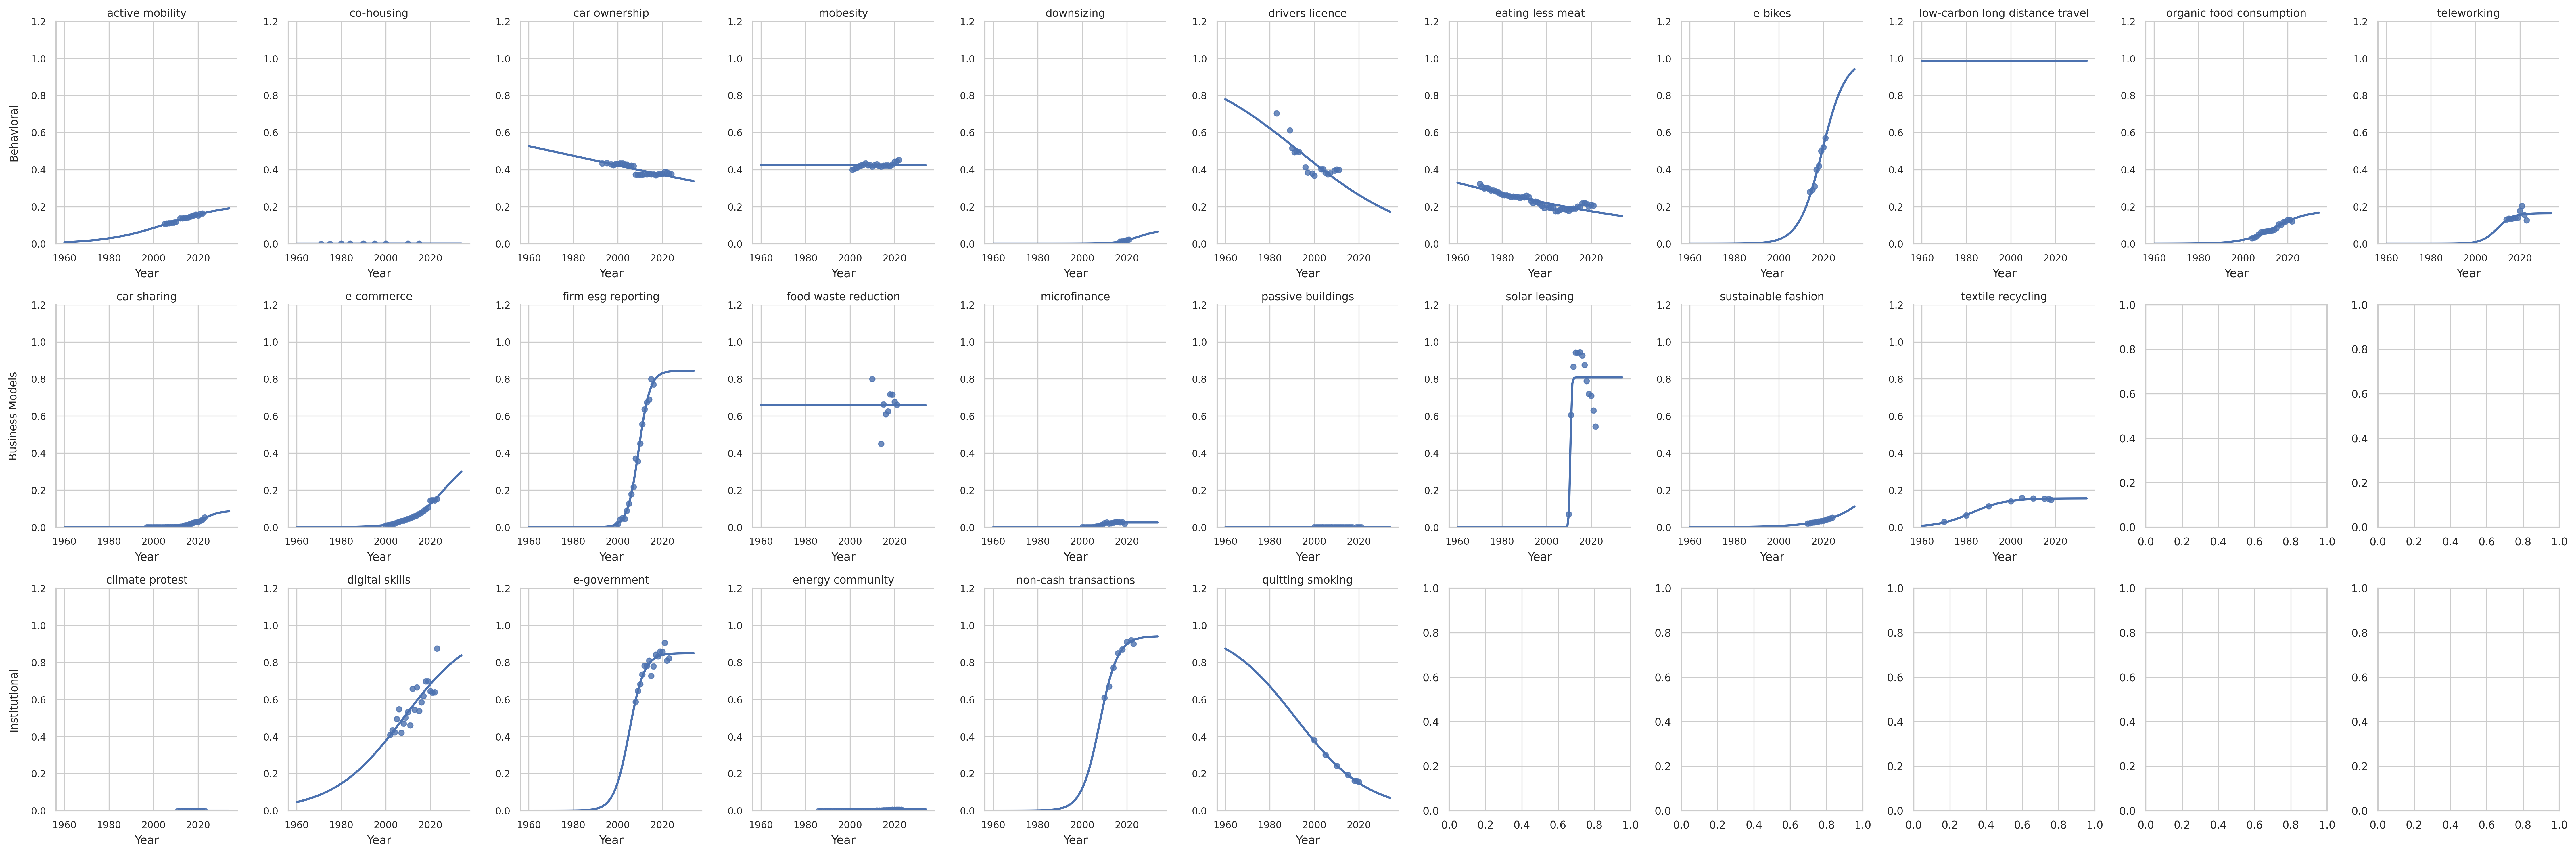

In [85]:
rng = np.random.default_rng(0)

# number of rows (categories) and max columns (panels)
row_labels = [x for x in cat_dict.keys()]

fig, axes = plt.subplots(n_categories, n_within_categories_max,
                         figsize=(30, 10),
                         squeeze=False)

for i, category in enumerate(cat_dict.keys()):
    for j, innovation_code in enumerate(cat_dict[category]):
        ax = axes[i, j]

        t0 = innovations_summary_df[innovations_summary_df["Innovation Code"] == innovation_code]["log_t0"].iloc[0]
        Dt = innovations_summary_df[innovations_summary_df["Innovation Code"] == innovation_code]["log_Dt"].iloc[0]
        K = innovations_summary_df[innovations_summary_df["Innovation Code"] == innovation_code]["log_K"].iloc[0]

        # call plotting function
        plot_line_scatter(ax, years_for_plotting, FPLogValue_with_scaling(years_for_plotting, t0, Dt, K), innovations_df[innovations_df["Innovation Code"] == innovation_code]["Year"], innovations_df[innovations_df["Innovation Code"] == innovation_code]["Value"],
                            title=f"""{next(key for key, value in metadata["Innovation Name"].items() if value == innovation_code)}""",
                            xlabel="Year", ylabel=None)

        # add row label on the left
        if j == 0:
            ax.set_ylabel(category_abbreviations_dict[category], fontsize=9, labelpad=10)

fig.tight_layout()
plt.show()
